In [1]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np


/Users/timmonkey/Desktop/Imperial/Spring Term/Natural Language Processing/Coursework/nlp_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
train = Dataset.load_from_disk("data/train")
val = Dataset.load_from_disk("data/val")
dev = Dataset.load_from_disk("data/dev")

In [3]:
# only want the text and label columns
train_val_df = pd.concat([pd.DataFrame(train), pd.DataFrame(val)])[['text', 'pcl']]
test_df = pd.DataFrame(dev)[['text', 'pcl']]

# Apply back-translation Augmenter

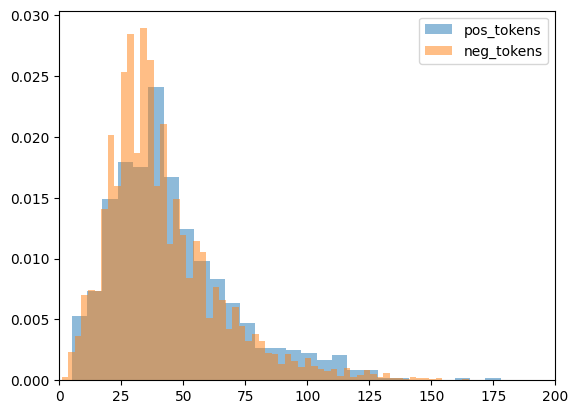

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

pos_tokens = CountVectorizer().fit_transform(train_val_df[train_val_df.pcl == 1].text.values)
pos_num_tokens = np.sum(pos_tokens.todense(), axis=1).flat


neg_tokens = CountVectorizer().fit_transform(train_val_df[train_val_df.pcl == 0].text.values)
neg_num_tokens = np.sum(neg_tokens.todense(), axis=1).flat

plt.hist(pos_num_tokens, density=True, alpha=0.5, bins='auto', label='pos_tokens')
plt.hist(neg_num_tokens, density=True, alpha=0.5, bins='auto', label='neg_tokens')
plt.xlim(0, 200)
plt.legend()
plt.show()

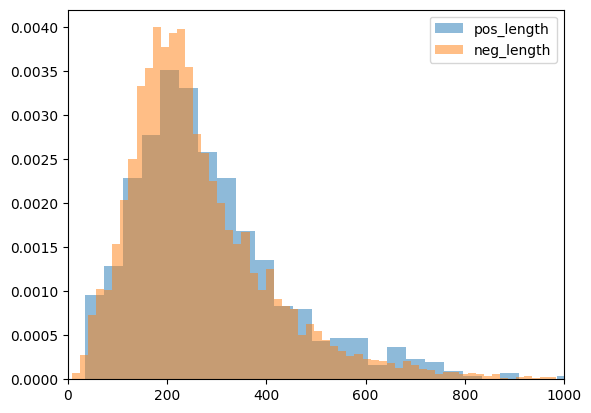

In [38]:
train_val_df[train_val_df.pcl == 1].text.apply(len)
train_val_df[train_val_df.pcl == 0].text.apply(len)
plt.hist(train_val_df[train_val_df.pcl == 1].text.apply(len).values, density=True, alpha=0.5, bins='auto', label='pos_length')
plt.hist(train_val_df[train_val_df.pcl == 0].text.apply(len).values, density=True, alpha=0.5, bins='auto', label='neg_length')
plt.xlim(0, 1000)
plt.legend()
plt.show()

In [93]:
import nlpaug.augmenter.word as naw

# can change language from any of the available models from https://huggingface.co/models?pipeline_tag=translation&sort=downloads&search=Helsinki-NLP
back_translate_aug = naw.BackTranslationAug(from_model_name='Helsinki-NLP/opus-mt-en-zh', to_model_name='Helsinki-NLP/opus-mt-zh-en')    
back_translated_text = back_translate_aug.augment(list(train_val_df[train_val_df.pcl == 1].text), num_thread=2)

data = {'text': back_translated_text, 'pcl': np.ones(len(back_translated_text))}
back_translated_df = pd.DataFrame(data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
augmented_df = pd.concat([train_val_df, back_translated_df])
augmented_df.sample(frac=1)

,text,pcl
959,"In the report , Madius added that the threat p...",0.0
6184,"Comprising two end terrace , two storey , hous...",0.0
5491,"IPOH : As Ramadan draws to a close , Muslims s...",1.0
3134,"KOTA KINABALU , May 21 ( Bernama ) -- A total ...",0.0
15,"But in this one a pair of trends were bucked ,...",0.0
...,...,...
823,"But Emil S ? nze , a local representative of t...",0.0
3671,Social venture gives sanitary supplies for wom...,0.0
2903,Pupils from poor families were given new shoes...,0.0
3295,Tell us a little about your character Rishi in...,0.0


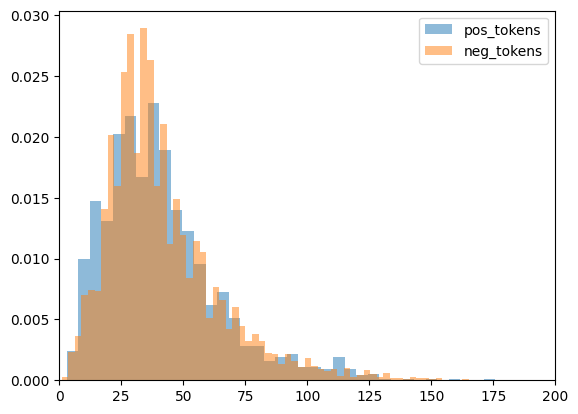

In [101]:
pos_tokens = CountVectorizer().fit_transform(augmented_df[augmented_df.pcl == 1].text.values)
pos_num_tokens = np.sum(pos_tokens.todense(), axis=1).flat

neg_tokens = CountVectorizer().fit_transform(augmented_df[augmented_df.pcl == 0].text.values)
neg_num_tokens = np.sum(neg_tokens.todense(), axis=1).flat

plt.hist(pos_num_tokens, density=True, alpha=0.5, bins='auto', label='pos_tokens')
plt.hist(neg_num_tokens, density=True, alpha=0.5, bins='auto', label='neg_tokens')
plt.xlim(0, 200)
plt.legend()
plt.show()

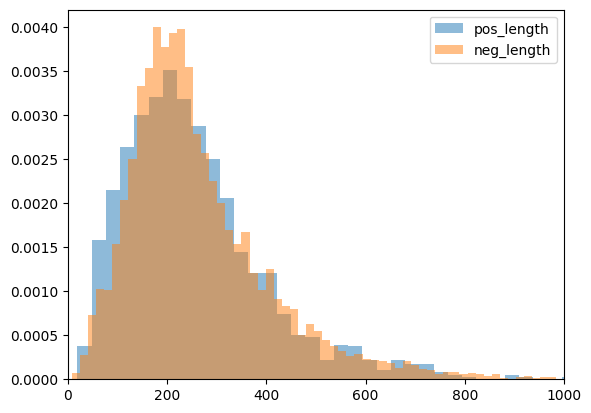

In [99]:
augmented_df[augmented_df.pcl == 1].text.apply(len)
augmented_df[augmented_df.pcl == 0].text.apply(len)
plt.hist(augmented_df[augmented_df.pcl == 1].text.apply(len).values, density=True, alpha=0.5, bins='auto', label='pos_length')
plt.hist(augmented_df[augmented_df.pcl == 0].text.apply(len).values, density=True, alpha=0.5, bins='auto', label='neg_length')
plt.xlim(0, 1000)
plt.legend()
plt.show()

## Apply Contextual Word Embedding Augmentation

In [102]:
context_word_aug = naw.ContextualWordEmbsAug(action='insert')
context_word_text = context_word_aug.augment(list(augmented_df[augmented_df.pcl == 1].text.values))

data = {'text': context_word_text, 'pcl': np.ones(len(context_word_text))}
context_word_df = pd.DataFrame(data)

In [103]:
augmented_df = pd.concat([augmented_df, context_word_df])
augmented_df = augmented_df.sample(frac=1)

In [120]:
augmented_df = augmented_df.reset_index()

# Attempt Model on Augmented Model

In [105]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import cuda
import numpy as np
from tqdm import tqdm

In [122]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [124]:
from torch.utils.data import Dataset

class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [125]:
encode_dict = {} # dictionary of all unique output labels

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

In [126]:
train_data = augmented_df[['text', 'pcl']].rename(columns={'text': "TITLE"})
dev_data = test_df[['text', 'pcl']].rename(columns={'text': "TITLE"})

train_data['ENCODE_CAT'] = train_data['pcl'].apply(lambda x: encode_cat(x))
dev_data['ENCODE_CAT'] = dev_data['pcl'].apply(lambda x: encode_cat(x))

In [127]:
train_set = Triage(dataframe=train_data, tokenizer=tokenizer, max_len=MAX_LEN)
dev_set = Triage(dataframe=dev_data, tokenizer=tokenizer, max_len=MAX_LEN)

In [128]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_set, **train_params)
testing_loader = DataLoader(dev_set, **test_params)

In [129]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [130]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [140]:
def train(epoch, model, loss_function, optimizer, device=DEVICE):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float64)

        outputs = model(ids, mask).flatten()
        loss = loss_function(outputs, targets)

        tr_loss += loss.item()
        pred_val = torch.where(torch.nn.functional.sigmoid(outputs.data) >= 0.5, 1, 0)
        # big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(pred_val, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%100==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 100 steps: {loss_step}")
            print(f"Training Accuracy per 100 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [132]:
def valid(model, testing_loader, loss_function, device=DEVICE):
    tr_loss =0 
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    tp = 0
    fp = 0
    fn = 0
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float64)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs.flatten(), targets)
            tr_loss += loss.item()
            pred_val = torch.where(torch.nn.functional.sigmoid(outputs.data) >= 0.5, 1, 0)
            n_correct += calcuate_accu(pred_val, targets)
            tp += torch.sum(torch.where(targets == 1, pred_val == targets, 0)).item()
            fp += torch.sum(torch.where(targets == 0, pred_val != targets, 0)).item()
            fn += torch.sum(torch.where(targets == 1, pred_val != targets, 0)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    epoch_f1 = tp / (tp + 0.5 * (fp + fn))
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    print(f"Validation F1 Epoch: {epoch_f1}")

    
    return epoch_accu, epoch_f1

In [141]:
weighted_loss_model = DistillBERTClass()
weighted_loss_model.to(DEVICE)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [142]:
# weighting = sum(train_val_df.pcl == 0) / sum(train_val_df.pcl == 1) # add weighting to positive samples
# loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weighting]))
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  weighted_loss_model.parameters(), lr=LEARNING_RATE)

In [143]:
for epoch in range(EPOCHS):
    train(epoch, weighted_loss_model, loss_function, optimizer)

0it [00:00, ?it/s]

Training Loss per 100 steps: 0.6713228831067681
Training Accuracy per 100 steps: 75.0


100it [06:12,  4.18s/it]

Training Loss per 100 steps: 0.5993281658450694
Training Accuracy per 100 steps: 72.02970297029702


200it [12:58,  3.92s/it]

Training Loss per 100 steps: 0.6109172639046652
Training Accuracy per 100 steps: 70.58457711442786


300it [19:34,  3.92s/it]

Training Loss per 100 steps: 0.6126772942005245
Training Accuracy per 100 steps: 70.01661129568106


400it [26:16,  3.98s/it]

Training Loss per 100 steps: 0.609610512585291
Training Accuracy per 100 steps: 69.9501246882793


500it [34:33,  6.34s/it]

Training Loss per 100 steps: 0.6010309594960794
Training Accuracy per 100 steps: 69.81037924151697


600it [43:36,  5.17s/it]

Training Loss per 100 steps: 0.5972487042410479
Training Accuracy per 100 steps: 69.96672212978369


700it [53:25,  6.02s/it]

Training Loss per 100 steps: 0.5910401170365526
Training Accuracy per 100 steps: 70.38159771754636


800it [1:01:40,  4.47s/it]

Training Loss per 100 steps: 0.581976653323346
Training Accuracy per 100 steps: 71.08302122347067


900it [1:08:28,  3.86s/it]

Training Loss per 100 steps: 0.5738829673169962
Training Accuracy per 100 steps: 71.83684794672585


1000it [1:14:56,  3.84s/it]

Training Loss per 100 steps: 0.5653724996941759
Training Accuracy per 100 steps: 72.42757242757243


1100it [1:21:39,  4.64s/it]

Training Loss per 100 steps: 0.5540667494200043
Training Accuracy per 100 steps: 73.18346957311535


1200it [1:28:39,  4.06s/it]

Training Loss per 100 steps: 0.5451033315279147
Training Accuracy per 100 steps: 73.68859283930058


1300it [1:35:16,  3.87s/it]

Training Loss per 100 steps: 0.5337297194937121
Training Accuracy per 100 steps: 74.45234435049962


1345it [1:38:13,  4.38s/it]

The Total Accuracy for Epoch 0: 74.67695454122897
Training Loss Epoch: 0.5308703692825026
Training Accuracy Epoch: 74.67695454122897


In [144]:
weighted_loss_acc, weighted_loss_f1 = valid(weighted_loss_model, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % weighted_loss_acc)
print("F1 on test data = %0.2f%%" % weighted_loss_f1)

Validation Loss per 100 steps: 0.2500517889857292
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.321276553104272
Validation Accuracy per 100 steps: 88.61386138613861
Validation Loss per 100 steps: 0.3140107339702139
Validation Accuracy per 100 steps: 89.05472636815921
Validation Loss per 100 steps: 0.3128758801326799
Validation Accuracy per 100 steps: 89.53488372093024
Validation Loss per 100 steps: 0.3231745918148994
Validation Accuracy per 100 steps: 88.90274314214464
Validation Loss per 100 steps: 0.33442290809875475
Validation Accuracy per 100 steps: 88.62275449101796
Validation Loss per 100 steps: 0.343310417777885
Validation Accuracy per 100 steps: 87.93677204658901
Validation Loss per 100 steps: 0.3345899531689503
Validation Accuracy per 100 steps: 88.37375178316691
Validation Loss per 100 steps: 0.3337548939387934
Validation Accuracy per 100 steps: 88.5143570536829
Validation Loss per 100 steps: 0.3319214258433943
Validation Accuracy per 100 steps: 88